In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report
from imblearn.over_sampling import RandomOverSampler
import keras
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, concatenate, Dense
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the dataset

In [3]:
df= pd.read_csv('/content/drive/MyDrive/Quera/what_to_buy/data/amazon_train.csv')
df

,UserID,ProductID,Rating,Timestamp
0,A3HICVLF4PFFMN,0594481813,5.0,2014-05-05
1,A2QBZA4S1ROX9Q,0594481813,3.0,2013-05-25
2,AT09WGFUM934H,0594481813,3.0,2013-08-31
3,AGAKHE014LQFU,0594481813,3.0,2013-09-18
4,A1S6B5QFWGVL5U,0594481813,4.0,2013-06-27
...,...,...,...,...
909196,ADLVFFE4VBT8,B00L3YHF6O,5.0,2014-07-05
909197,AWPODHOB4GFWL,B00L3YHF6O,5.0,2014-07-10
909198,A3A4ZAIBQWKOZS,B00L3YHF6O,5.0,2014-07-07
909199,A34BZM6S9L7QI4,B00LGQ6HL8,5.0,2014-07-17


# Preprocessing

In [4]:
# Encoding UserID and ProductID columns
le_user = LabelEncoder()
df['UserEnc'] = le_user.fit_transform(df['UserID'].values)

le_product = LabelEncoder()
df['ProductEnc'] = le_product.fit_transform(df['ProductID'].values)

In [5]:
# Scaling the Rating column
sc= MinMaxScaler()
df[['Rating']]= sc.fit_transform(df[['Rating']])

In [6]:
df['Rating_Class'] = (df['Rating'] >= 0.5).astype(int)

In [7]:
X = df[['UserEnc', 'ProductEnc']]
y = df['Rating_Class']

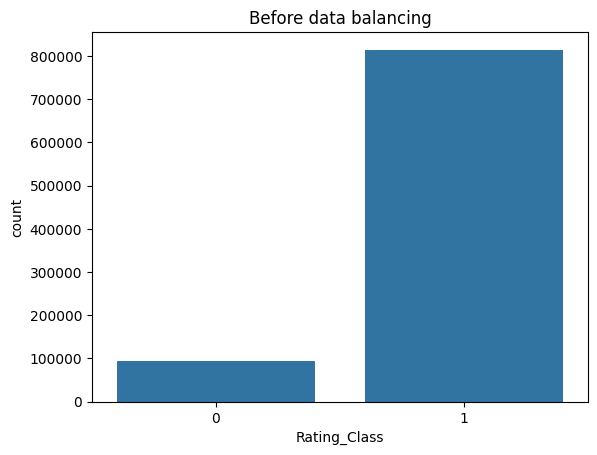

In [8]:
sns.countplot(x=y)
plt.title('Before data balancing')
plt.show()

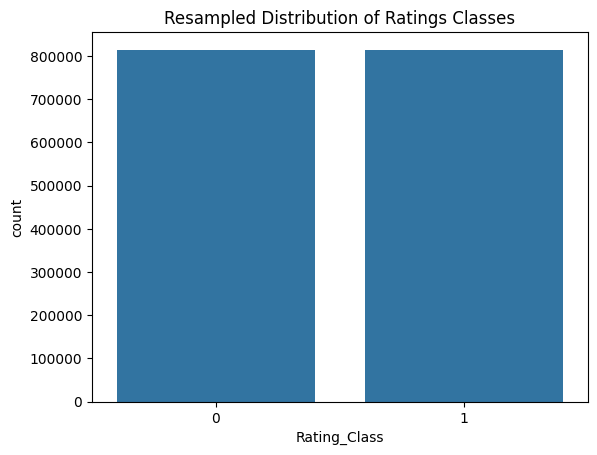

In [9]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

sns.countplot(x=y_resampled)
plt.title('Resampled Distribution of Ratings Classes')
plt.show()

In [ ]:
user_ids_resampled = X_resampled['UserEnc'].values
item_ids_resampled = X_resampled['ProductEnc'].values
ratings = df['Rating'].values

num_users = df['UserEnc'].nunique()
num_items = df['ProductEnc'].nunique()

user_train, user_test, item_train, item_test, y_train, y_test = train_test_split(
    user_ids_resampled, item_ids_resampled, y_resampled, test_size=0.2, random_state=42
)

y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Modeling

In [ ]:
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding = Embedding(input_dim=num_users, output_dim=8, name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=8, name='item_embedding')(item_input)

user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

user_bias = Embedding(input_dim=num_users, output_dim=1, name='user_bias')(user_input)
item_bias = Embedding(input_dim=num_items, output_dim=1, name='item_bias')(item_input)

score = Dot(axes=1)([user_vec, item_vec])
score = Add()([score, Flatten()(user_bias), Flatten()(item_bias)])
output = Dense(1, activation='sigmoid')(score)

In [ ]:
model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Training phase
model.fit([user_train, item_train], y_train,
          epochs=10,
          batch_size=32,
          validation_split=0.2)

Epoch 1/10
32583/32583 ━━━━━━━━━━━━━━━━━━━━ 450s 14ms/step - accuracy: 0.7080 - loss: 0.5480 - val_accuracy: 0.8968 - val_loss: 0.2621
Epoch 2/10
32583/32583 ━━━━━━━━━━━━━━━━━━━━ 393s 12ms/step - accuracy: 0.9498 - loss: 0.1384 - val_accuracy: 0.9326 - val_loss: 0.1938
Epoch 3/10
32583/32583 ━━━━━━━━━━━━━━━━━━━━ 373s 11ms/step - accuracy: 0.9756 - loss: 0.0698 - val_accuracy: 0.9423 - val_loss: 0.1761
Epoch 4/10
32583/32583 ━━━━━━━━━━━━━━━━━━━━ 403s 12ms/step - accuracy: 0.9835 - loss: 0.0485 - val_accuracy: 0.9471 - val_loss: 0.1683
Epoch 5/10
32583/32583 ━━━━━━━━━━━━━━━━━━━━ 415s 13ms/step - accuracy: 0.9869 - loss: 0.0385 - val_accuracy: 0.9497 - val_loss: 0.1639
Epoch 6/10
32583/32583 ━━━━━━━━━━━━━━━━━━━━ 378s 12ms/step - accuracy: 0.9889 - loss: 0.0332 - val_accuracy: 0.9515 - val_loss: 0.1613
Epoch 7/10
32583/32583 ━━━━━━━━━━━━━━━━━━━━ 371s 11ms/step - accuracy: 0.9901 - loss: 0.0299 - val_accuracy: 0.9526 - val_loss: 0.1609
Epoch 8/10
32583/32583 ━━━━━━━━━━━━━━━━━━━━ 377s 12ms/s

# Evaluation

In [ ]:
df['Rating_Class'] = df['Rating'].apply(lambda x: 1 if x in [4, 5] else 0)
y_pred_proba = model.predict([user_test, item_test])
y_pred = (y_pred_proba >= 0.5).astype(int)

precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(classification_report(y_test, y_pred))

10182/10182 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
Precision: 0.9701
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96    163205
         1.0       0.97      0.94      0.95    162617

    accuracy                           0.95    325822
   macro avg       0.95      0.95      0.95    325822
weighted avg       0.95      0.95      0.95    325822

